In [4]:
import torch

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'

print("Device: " + device)

Device: mps


In [17]:
import math
from dataclasses import dataclass

from torch import nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, AdamW


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension
        
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd*4)
        self.act = nn.GELU()
        self.c_proj = nn.Linear(config.n_embd*4, config.n_embd)
        
    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    

class GPT2Block(nn.Module):
    def __init__(self, config):
        super(GPT2Block, self).__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super(GPT, self).__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    
    def forward(self, x, targets=None):
        x = self.transformer['wte'](x)
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = x + self.transformer['wpe'](pos)
        for block in self.transformer['h']:
            x = block(x)
        x = self.transformer['ln_f'](x)
        x = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(x.view(-1, x.size(-1)), targets.reshape(-1))
        return x, loss
    
    
model = GPT.from_pretrained('gpt2').to(device)

loading weights from pretrained gpt: gpt2


In [18]:
from transformers import GPT2Tokenizer


tokenizer = GPT2Tokenizer.from_pretrained('./gpt2_local')

model.eval()

samples = 5
tokens = tokenizer.encode("My wife is working as a")
tokens = torch.tensor(tokens, dtype=torch.long, device=device) # (8,)
tokens = tokens.unsqueeze(0).repeat(samples, 1) # (5, 8)
while tokens.shape[1] < 10:
    with torch.no_grad():
        logits, loss = model(tokens)
        logits = logits[:, -1, :] # (5, 50257)
        probs = F.softmax(logits, dim=-1)
        topk = torch.topk(logits, 5, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 20, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        tokens = torch.cat([tokens, xcol], dim=-1)
    
for i in range(tokens.shape[0]):    
    print("> " + tokenizer.decode(tokens[i].tolist()))

> My wife is working as a chef, working with
> My wife is working as a nurse in the clinic
> My wife is working as a teacher in a small
> My wife is working as a carpenter for the
> My wife is working as a housekeeper, and


In [19]:
from torch.optim import AdamW

B, T = 5, 8
data = open('women_in_tech.txt').read()
data = tokenizer.encode(data)
batches = [data[i:i + T + 1] for i in range(0, len(data), T) if len(data[i:i + T + 1]) == T + 1]
batches = torch.tensor(batches, dtype=torch.long)
if len(batches) % B != 0:
    batches = batches[:-(len(batches) % B)]
batches = batches.reshape(-1, B, T + 1) # (N, B, T+1)


for epoch in range(3):
    cum_loss = 0
    for batch in batches:
        x = batch[:, :-1].clone().to(device)
        y = batch[:, 1:].clone().to(device)
        opt = AdamW(model.parameters(), lr=1e-4)
        opt.zero_grad()
        logits, loss = model(x, y)
        cum_loss += loss.item()
        loss.backward()
        opt.step()
    cum_loss /= len(batches)
    print(f'epoch {epoch} loss: {cum_loss:.2f}')

epoch 0 loss: 3.73
epoch 1 loss: 2.03
epoch 2 loss: 1.16


In [20]:
model_base = GPT.from_pretrained('gpt2').to(device)

loading weights from pretrained gpt: gpt2


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

input = open("women_in_tech.txt", "r").read()
input_ids = tokenizer.encode(input, return_tensors="pt").to(device)
target_ids = input_ids.clone()[0, 1:]
input_ids = input_ids[:, :-1]

def get_top_token_ids(rep):
    prob = torch.softmax(rep @ model.transformer.wte.weight.T, dim=-1)
    indices = torch.argmax(prob, dim=-1)
    return indices

num_tokens = input_ids.shape[1]
num_layers = len(model.transformer.h)
rep = torch.zeros((num_layers, num_tokens), device=device, dtype=torch.int64)
def hook(_, args, output, idx):
    token_idx = output[0].shape[1]
    output_vec = output[0][:,:]
    rep[idx] = get_top_token_ids(output_vec)

hooks = []
for i, h in enumerate(model.transformer.h):
    hk = h.register_forward_hook(lambda module, args, output, idx=i: hook(module, args, output, idx))
    hooks.append(hk)

try:
    logits, _ = model(input_ids)
    logits_base, _ = model_base(input_ids)
    logits = logits[0]
    logits_base = logits_base[0]
except Exception as e:
    print("Error in model call: ",e)

for h in hooks:
    h.remove()

ip = [tokenizer.decode(int(i)) for i in input_ids[0]]
target = [tokenizer.decode(int(i)) for i in target_ids]

output_ids = torch.argmax(logits, dim=-1)
output = [tokenizer.decode(int(i)) for i in output_ids]
stablised_layer = torch.argmin((rep - output_ids) ** 2, dim=0).to('cpu')

base_output_ids = torch.argmax(logits_base, dim=-1)
base_output = [tokenizer.decode(int(i)) for i in base_output_ids]
base_stablised_layer = torch.argmin((rep - base_output_ids) ** 2, dim=0).to('cpu')

pd.DataFrame({"input": ip,"target": target, "base_output":base_output, "output": output,  "base_layer": base_stablised_layer, "layer": stablised_layer, "diff":  stablised_layer - base_stablised_layer})
# pd.DataFrame({'layer':stablised_layer}).hist()

,input,target,base_output,output,base_layer,layer,diff
0,My,wife,\n,wife,0,11,11
1,wife,is,and,is,0,0,0
2,is,working,a,working,3,0,-3
3,working,at,on,at,2,6,4
4,at,a,a,a,8,8,0
...,...,...,...,...,...,...,...
281,learning,and,",",",",8,8,0
282,and,natural,machine,machine,1,1,0
283,natural,language,language,language,11,11,0
284,language,processing,processing,processing,5,5,0


array([[<Axes: title={'center': 'layer'}>]], dtype=object)

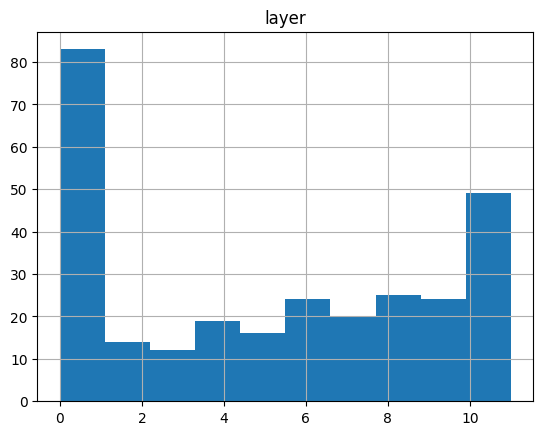

In [26]:
pd.DataFrame({'layer':stablised_layer}).hist()

array([[<Axes: title={'center': 'layer'}>]], dtype=object)

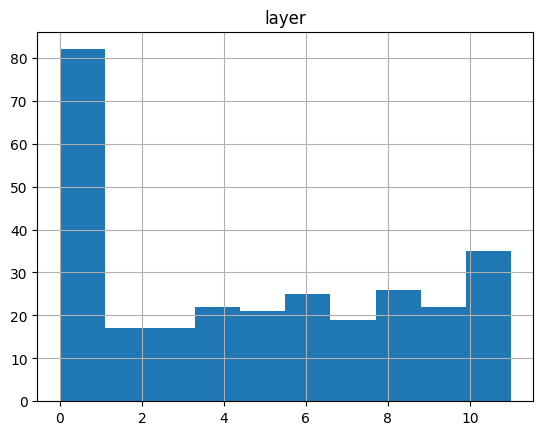

In [27]:
pd.DataFrame({'layer':base_stablised_layer}).hist()

array([[<Axes: title={'center': 'diff'}>]], dtype=object)

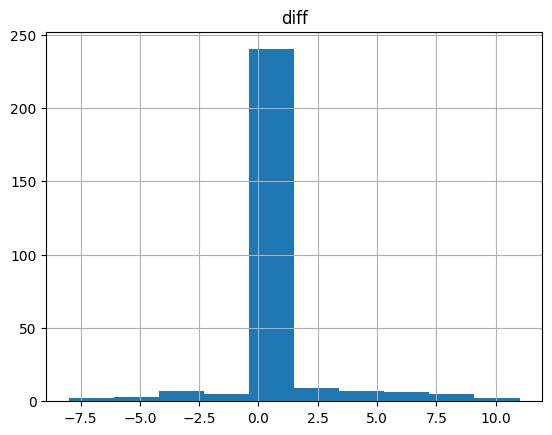

In [28]:
pd.DataFrame({'diff':stablised_layer - base_stablised_layer}).hist()